In [116]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random

## Dataset Creation

In [117]:
min_len = 2
max_len = 9
num_samples = 5000
eval_samples = 1000

train_dataset = []
test_dataset = []

for i in range(num_samples+eval_samples):
    len = random.sample(range(min_len, max_len+1), 1)
    x_1 = torch.rand(1, len[0])
    x_2 = torch.zeros(1, len[0])
    pos = random.sample(range(len[0]), 2)

    x_2[0, pos[0]] = 1
    x_2[0, pos[1]] = 1

    x = torch.cat((x_1,x_2), 0)
    y = torch.dot(x_1.reshape(len[0], ), x_2.reshape(len[0], ))
    x.requires_grad = True
    y.requires_grad = True

    if(i<num_samples):
        train_dataset.append([x,y])
    else:
        test_dataset.append([x,y])
    


## Elmon RNN

In [118]:
class ElmonRNN(torch.nn.Module):

    def __init__(self, input_dim= 2, memory_size = 5, output_dim = 1):

        super(ElmonRNN, self).__init__()
        self.memory_size = memory_size
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Wxh = torch.nn.Parameter(torch.randn(( self.memory_size, self.input_dim)))
        self.Whh = torch.nn.Parameter(torch.randn(( self.memory_size, self.memory_size)))
        self.Why = torch.nn.Parameter(torch.randn(( self.output_dim, self.memory_size)))

        self.bh = torch.nn.Parameter(torch.randn(( self.memory_size)))
        self.by = torch.nn.Parameter(torch.randn(( self.output_dim)))


    def forward(self, x):
        
        dims = x.shape
        len = dims[1]
        h = torch.zeros(self.memory_size)

        for t in range(len):
            h = torch.tanh( torch.matmul( self.Wxh, x[:, t]) + torch.matmul(self.Whh, h)+ self.bh)
        
        out = torch.matmul(self.Why , h)+ self.by
        return out

rnn = ElmonRNN()


#### Training the Elmon RNN

In [119]:
def MSELoss(outputs, labels):
    loss = torch.square((outputs - labels))
    return loss

In [120]:
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
num_epochs = 5
batch_sz = 100

In [121]:
elmon_rnn_loss = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    random.shuffle(train_dataset)
    # random.shuffle(dataset)
    for j in range(0, num_samples, batch_sz):
        for i, data in enumerate(train_dataset[j:j+batch_sz]):
            # get the inputs; data is a list of [inputs, labels]

            inputs = data[0]
            labels = data[1].reshape((1))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # with torch.autograd.detect_anomaly():
            outputs = rnn(inputs)     
            loss = MSELoss(outputs, labels)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
    loss = (running_loss/num_samples)
    print(f'Epoch = {epoch + 1} and loss: {loss}')
    elmon_rnn_loss.append(loss)
  

print('Finished Training of Elmon rnn')

Epoch = 1 and loss: 0.15419207231949464
Epoch = 2 and loss: 0.11986126458063254
Epoch = 3 and loss: 0.06623019817640254
Epoch = 4 and loss: 0.039662152174283156
Epoch = 5 and loss: 0.029656670083681287
Finished Training of Elmon rnn


#### Prediction from the Elmon RNN

In [122]:
running_loss =0.0
rnn.eval()
for i, data in enumerate(test_dataset):
    # get the inputs; data is a list of [inputs, labels]

    inputs = data[0]
    labels = data[1].reshape((1))

    # forward + backward + optimize
    # with torch.autograd.detect_anomaly():
    outputs = rnn(inputs)     
    loss = MSELoss(outputs, labels)
    running_loss += loss.item()
ernnLoss = (running_loss/eval_samples)
print(f'Testing loss: {ernnLoss}')
  

Testing loss: 0.022133088999301633


## LSTM

In [123]:
class LSTM(torch.nn.Module):

    def __init__(self, input_dim= 2, cell_sz = 10, output_dim = 1):

        super(LSTM, self).__init__()
        self.cell_sz = cell_sz
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Wi = torch.nn.Parameter(torch.randn(( self.cell_sz, self.input_dim + self.cell_sz)))
        self.Wc = torch.nn.Parameter(torch.randn(( self.cell_sz, self.input_dim + self.cell_sz)))
        self.Wf = torch.nn.Parameter(torch.randn(( self.cell_sz, self.input_dim + self.cell_sz)))
        self.Wo = torch.nn.Parameter(torch.randn(( self.cell_sz, self.input_dim + self.cell_sz)))
        self.Why = torch.nn.Parameter(torch.randn(( self.output_dim, self.cell_sz)))

        self.bi = torch.nn.Parameter(torch.randn(( self.cell_sz)))
        self.bf = torch.nn.Parameter(torch.randn(( self.cell_sz)))
        self.bc = torch.nn.Parameter(torch.randn(( self.cell_sz)))
        self.bo = torch.nn.Parameter(torch.randn(( self.cell_sz)))
        self.bhy = torch.nn.Parameter(torch.randn(( self.output_dim)))


    def forward(self, x):
        
        dims = x.shape
        len = dims[1]
        h = torch.zeros(self.cell_sz)
        C = torch.zeros(self.cell_sz)

        for t in range(len):

            ht_1_xt = torch.cat((h, x[:, t]), 0)
            
            # LSTM gates
            it = torch.sigmoid( torch.matmul( self.Wi, ht_1_xt)+ self.bi )
            ft = torch.sigmoid( torch.matmul( self.Wf, ht_1_xt) + self.bf  )
            ot = torch.sigmoid( torch.matmul( self.Wo, ht_1_xt) + self.bo )

            C_dash_t = torch.tanh( torch.matmul( self.Wc, ht_1_xt)+ self.bc )

            C = torch.mul(ft, C) + torch.mul(it, C_dash_t)

            h = torch.mul(ot, torch.tanh(C))
            
        out = torch.matmul( self.Why, h)+ self.bhy
        return out

lstm = LSTM()

#### Training the LSTM

In [124]:
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.01)

In [125]:
lstm_loss = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    random.shuffle(train_dataset)
    for j in range(0, num_samples, batch_sz):
        for i, data in enumerate(train_dataset[j:j+batch_sz]):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs = data[0]
            labels = data[1].reshape((1))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # with torch.autograd.detect_anomaly():
            outputs = lstm(inputs)     
            loss = MSELoss(outputs, labels)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()

    loss = (running_loss/num_samples)
    print(f'Epoch = {epoch + 1} and loss: {loss}')
    lstm_loss.append(loss)
  

print("Finished Training of LSTM")

Epoch = 1 and loss: 0.021947368252711916
Epoch = 2 and loss: 0.004163307948793118
Epoch = 3 and loss: 0.0021916690010598495
Epoch = 4 and loss: 0.0010658559574546467
Epoch = 5 and loss: 0.000899066974146482
Finished Training of LSTM


#### Prediction from LSTM

In [126]:
running_loss =0.0
lstm.eval()
for i, data in enumerate(test_dataset):
    # get the inputs; data is a list of [inputs, labels]

    inputs = data[0]
    labels = data[1].reshape((1))

    # forward + backward + optimize
    # with torch.autograd.detect_anomaly():
    outputs = lstm(inputs)     
    loss = MSELoss(outputs, labels)
    running_loss += loss.item()
lstmLoss = (running_loss/eval_samples)
print(f'Testing loss: {lstmLoss}')
  

Testing loss: 0.00021381875950689277


## GRU

In [127]:
class GRU(torch.nn.Module):

    def __init__(self, input_dim= 2, hid_dim = 10, out_dim = 1):

        super(GRU, self).__init__()
        self.hid_dim = hid_dim
        self.input_dim = input_dim
        self.out_dim = out_dim

        self.Wz = torch.nn.Parameter(torch.randn(( self.hid_dim, self.input_dim + self.hid_dim)))
        self.Wr = torch.nn.Parameter(torch.randn(( self.hid_dim, self.input_dim + self.hid_dim)))
        self.W = torch.nn.Parameter(torch.randn(( self.hid_dim, self.input_dim + self.hid_dim)))
        self.Why = torch.nn.Parameter(torch.randn(( self.out_dim, self.hid_dim)))

        self.bz = torch.nn.Parameter(torch.randn(( self.hid_dim)))
        self.br = torch.nn.Parameter(torch.randn((self.hid_dim)))
        self.b = torch.nn.Parameter(torch.randn(( self.hid_dim)))
        self.bhy = torch.nn.Parameter(torch.randn(( self.out_dim)))
        

    def forward(self, x):
        
        dims = x.shape
        len = dims[1]
        h = torch.zeros((self.hid_dim))

        for t in range(len):

            ht_1_xt = torch.cat((h, x[:, t]), 0)
            
            #  GRU gates
            zt = torch.sigmoid( torch.matmul( self.Wz, ht_1_xt) + self.bz)
            rt = torch.sigmoid( torch.matmul( self.Wr, ht_1_xt)+ self.br )

            ht_rt = torch.cat((torch.mul(rt, h), x[:, t]), 0)
            h_dash_t = torch.tanh( torch.matmul( self.W, ht_rt) + self.b)

            h = torch.mul(1-zt, h) + torch.mul(zt, h_dash_t)
            
        out = torch.matmul( self.Why, h)+ self.bhy
        return out

gru = GRU()

#### Training the LSTM

In [128]:
optimizer = torch.optim.Adam(gru.parameters(), lr=0.01)

In [129]:
gru_loss = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    random.shuffle(train_dataset)
    for j in range(0, num_samples, batch_sz):
        for i, data in enumerate(train_dataset[j:j+batch_sz]):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs = data[0]
            labels = data[1].reshape((1))

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # with torch.autograd.detect_anomaly():
            outputs = gru(inputs)     
            loss = MSELoss(outputs, labels)
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
    loss = (running_loss/num_samples)
    print(f'Epoch = {epoch + 1} and loss: {loss}')
    gru_loss.append(loss)
  

print("Finished Training of GRU")

Epoch = 1 and loss: 0.02617255956391519
Epoch = 2 and loss: 0.0032096395183546763
Epoch = 3 and loss: 0.001499893348542161
Epoch = 4 and loss: 0.0009566579726150522
Epoch = 5 and loss: 0.0007975512212371491
Finished Training of GRU


#### Predicting from GRU

In [130]:
running_loss =0.0
gru.eval()
for i, data in enumerate(test_dataset):
    # get the inputs; data is a list of [inputs, labels]

    inputs = data[0]
    labels = data[1].reshape((1))

    # forward + backward + optimize
    # with torch.autograd.detect_anomaly():
    outputs = gru(inputs)     
    loss = MSELoss(outputs, labels)
    running_loss += loss.item()
gruLoss = (running_loss/eval_samples)
print(f'Testing loss: {gruLoss}')
  

Testing loss: 0.0003561706333989356


## Baselines and Comparisons

In [131]:
running_loss = 0.0
random.shuffle(train_dataset)
for j in range(0, num_samples):
            
    inputs = data[0]
    labels = data[1].reshape((1))


    # forward + backward + optimize
    # with torch.autograd.detect_anomaly():
    outputs = torch.tensor([1])   
    loss = MSELoss(outputs, labels)
    running_loss += loss.item()
baseline_loss = (running_loss/num_samples)
print(f'Baseline loss: {baseline_loss}')

Baseline loss: 0.16778838634490967


In [132]:
running_loss =0.0
for i, data in enumerate(test_dataset):
    # get the inputs; data is a list of [inputs, labels]

    inputs = data[0]
    labels = data[1].reshape((1))

    # forward + backward + optimize
    # with torch.autograd.detect_anomaly():
    outputs = torch.tensor([1]) 
    loss = MSELoss(outputs, labels)
    running_loss += loss.item()
baseLoss = (running_loss/eval_samples)
print(f'Testing loss: {baseLoss}')

Testing loss: 0.1574774493059224


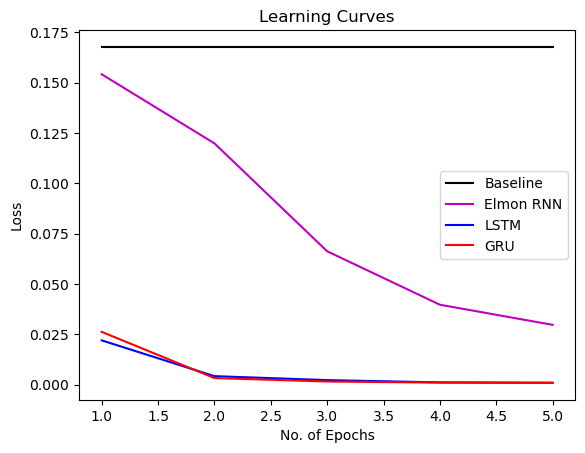

In [141]:
# Loss comparison training

x = np.arange(1, num_epochs+1)
y = np.full((num_epochs),baseline_loss )

plt.plot(x, y, color= 'k', label = "Baseline")  
plt.plot(x, elmon_rnn_loss,color= 'm', label = "Elmon RNN")  
plt.plot(x, lstm_loss,color= 'b',  label = "LSTM")
plt.plot(x, gru_loss, color= 'r', label = "GRU")
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')

plt.title('Learning Curves')
plt.legend()
plt.show()

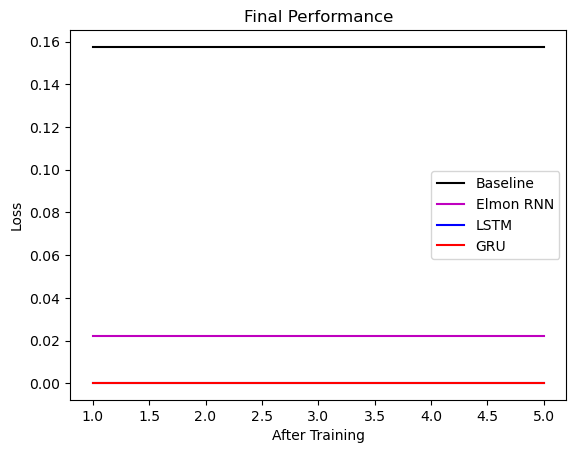

In [142]:
# Final Performance Comparison 
x = np.arange(1, num_epochs+1)

ernnLoss = np.full(num_epochs, ernnLoss)
lstmLoss = np.full(num_epochs, lstmLoss)
gruLoss = np.full(num_epochs, gruLoss)
baseLoss = np.full(num_epochs, baseLoss)

plt.plot(x, baseLoss, color= 'k', label = "Baseline")  
plt.plot(x, ernnLoss,color= 'm', label = "Elmon RNN")  
plt.plot(x, lstmLoss,color= 'b',  label = "LSTM")
plt.plot(x, gruLoss, color= 'r', label = "GRU")
plt.xlabel('After Training')
plt.ylabel('Loss')

plt.title('Final Performance')
plt.legend()
plt.show()